In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
eyes_closed = np.load('/homes/v20subra/S4B2/eLORETA extensive validation/eyes_closed_20_one_epoch.npy',allow_pickle='True')
eyes_open = np.load('/homes/v20subra/S4B2/eLORETA extensive validation/eyes_open_20_one_epoch.npy',allow_pickle='True')

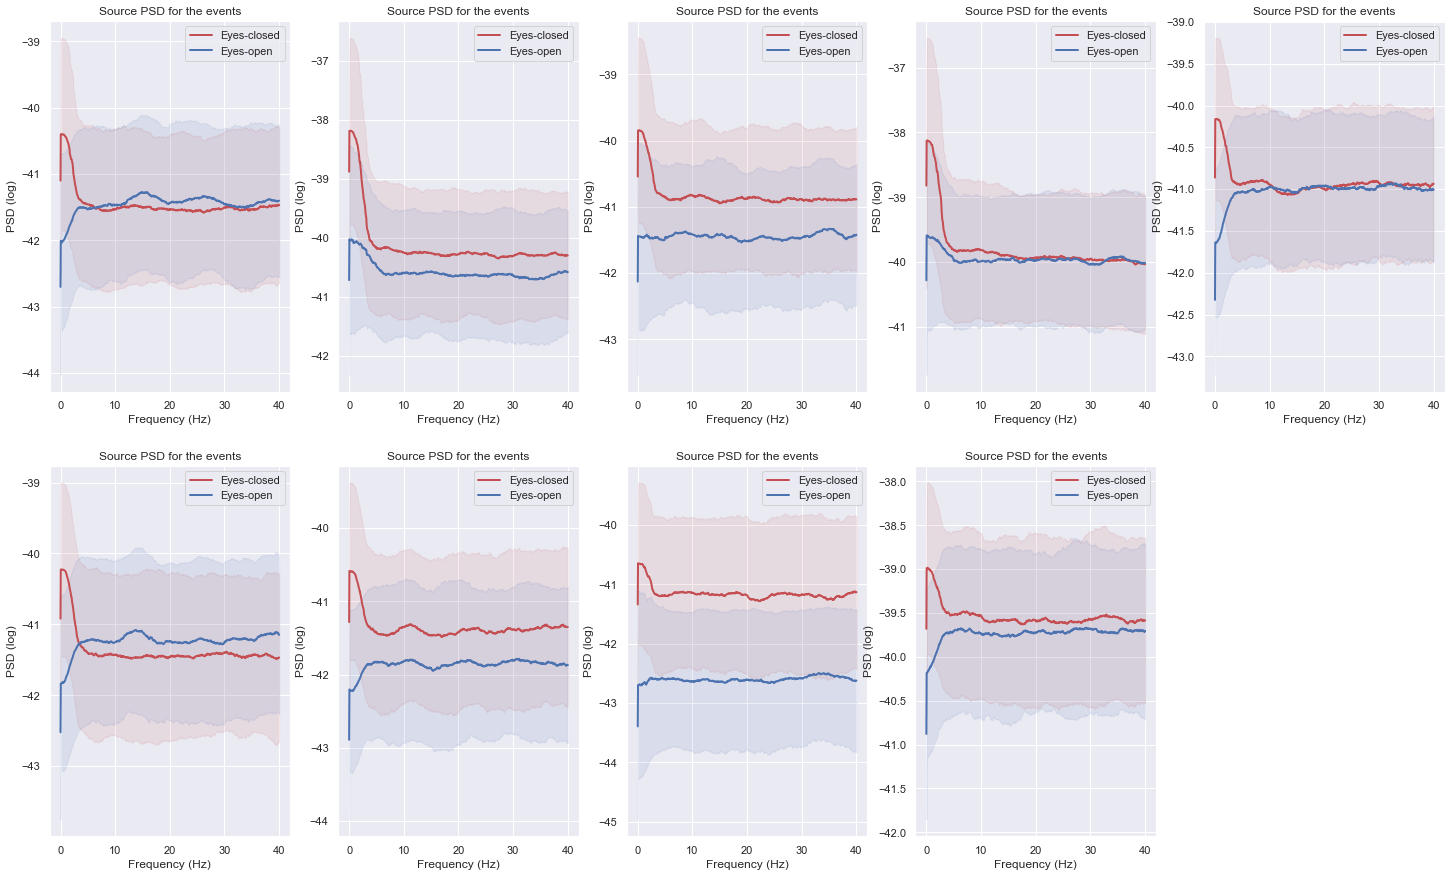

In [6]:
import seaborn as sns
sns.set_theme()
def mean_std(data1):

    m = np.mean(np.log(data1.data.T),axis=1)
    s = 2 * np.std(np.log(data1.data.T),axis=1)
    top = m+s
    bottom = m-s
    return m,s,top,bottom
stcs_to_plot = [eyes_closed.item(),eyes_open.item()]
#def lowISC_high_ISC(*typ):
a = 2  # number of rows
b = 5  # number of columns
fig =plt.figure(figsize=(25,15))

c = 1  # initialize plot counter
for i in range(9):
    
    plt.subplot(a, b, c)

    m,s,top,bottom= mean_std(stcs_to_plot[0][i])
    plt.plot(stcs_to_plot[0][i].times,m, linewidth=2,color='r',label='Eyes-closed') 
    plt.fill_between(stcs_to_plot[0][i].times,bottom, top, color='r', alpha=.1)

    m,s,top,bottom= mean_std(stcs_to_plot[1][i])
    plt.plot(stcs_to_plot[1][i].times,m, linewidth=2,color='b',label='Eyes-open')
    plt.fill_between(stcs_to_plot[1][i].times,bottom, top, color='b', alpha=.1)
    plt.legend()

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (log)')
    plt.title('Source PSD for the events')

    c = c + 1
plt.show()
fig.savefig('/homes/v20subra/S4B2/eLORETA extensive validation/eloreta_setup_validation_event_20_oneEpoch.png')
